# Проект "Анализ и прогнозирование снижения активности пользователей он-лайн магазина "В один клик"

**Заказчик:** интернет-магазин "В один клик" (Далее - Заказчик).

**Цели проекта:** 
- Провести анализ информации о постоянных покупателях Заказчика (далее - Клиенты) с целью определения ключевых метрик, влияющих на покупательскую активность Клиентов (далее - Таргет).
- Разработать модель машинного обучения (далее - МО) для прогнозирования вероятности снижения Таргета в следующие три месяца.
- Используя данные модели МО разработать решение для персонализированных предложений и выдать рекомендации Заказчику.

## 0. Подготовка ноутбука к работе

In [1]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Data preprocessing
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   PolynomialFeatures)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Pipeline creation
from sklearn.pipeline import Pipeline

# Model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Additional tools
import phik
import shap

In [4]:
# Объявление констант
RANDOM_STATE = 42
TEST_SIZE=0.2

In [5]:
# Настройка параметров отображения данных
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
# Загрузка данных

# Информация о Клиенте (поведение, коммуникация)
customer = pd.read_csv('https://market_file.csv')
# Информация о тратах Клиентов за определённый период
customer_expenditure = pd.read_csv('https://datasets/market_money.csv')
# Информация о времени, проведённом Клиентами за определённый период
customer_time = pd.read_csv('https://market_time.csv')
# Информация о прибыли с Клиентов за последние три месяца
customer_profit = pd.read_csv('https://money.csv', sep=';', decimal=',')

In [7]:
customer_profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [8]:
# Функция для вывода основной информации
def main_info (df):
    """
    Displays basic information about the DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - None
    """

    print("\nDataFrame Shape:")
    print(f"\nЧисло наблюдений: {df.shape[0]}")
    print(f"\nЧисло признаков: {df.shape[1]}")

    print("\nDataFrame Info:")
    display(df.info())

    print("DataFrame Head:")
    display(df.head())

    print("Percentage of Missing values:")
    display(df.isna().mean().sort_values(ascending=False))

    print("Duplicates:")
    display(df.duplicated().sum())
    return None

In [9]:
# Функция для выделения числовых значений датафрейма
def numeric(df):
    """
    Identifies numeric columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    A list of column names containing numeric data types.
    """
    columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    return columns

In [10]:
# Функция для выделения не числовых значений датафрейма
def non_numeric(df):
    """
    Identifies non-numeric columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    A list of column names containing non-numeric data types.
    """
    columns = [col for col in df.columns if df[col].dtype == 'object']
    return columns

In [11]:
# Функция для построения диаграмм распределения числовых значений
def plot_density_and_boxplot(data, column):
    """
    Plot density plot and boxplot for a given column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot density plot
    sns.histplot(data[column], bins=50, color='lightgreen', kde=True, ax=axs[0])
    axs[0].set_title(f'Density Plot of {column}')

    # Plot boxplot
    axs[1].boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[1].set_title(f'Boxplot of {column}')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [12]:
# Функция для построения круговой диаграммы категориальных данных
def plot_pie_chart(df, column):
    """
    Plot a pie chart to visualize the distribution of categorical data in the specified column of the DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    # Group by the specified column and calculate counts and ratios
    data = df.groupby(column)[column].agg(count=('count'))
    data['ratio (%)'] = round(data['count'] / len(df) * 100)

    # Extract labels and sizes
    labels = data.index
    sizes = data['ratio (%)']

    # Plot the pie chart
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'{column} ratio')
    plt.show()

## 1. EDA (Анализ исходных данных).

### 1.1. Данные о Клиентах

#### 1.1.1 Первичный анализ и предобработка

In [13]:
# Общая информация по датафрейму
main_info(customer)


DataFrame Shape:

Число наблюдений: 1300

Число признаков: 13

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_про

None

DataFrame Head:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


Percentage of Missing values:


id                                    0.00
Покупательская активность             0.00
Тип сервиса                           0.00
Разрешить сообщать                    0.00
Маркет_актив_6_мес                    0.00
Маркет_актив_тек_мес                  0.00
Длительность                          0.00
Акционные_покупки                     0.00
Популярная_категория                  0.00
Средний_просмотр_категорий_за_визит   0.00
Неоплаченные_продукты_штук_квартал    0.00
Ошибка_сервиса                        0.00
Страниц_за_визит                      0.00
dtype: float64

Duplicates:


0

In [14]:
# Проверка отсутствия дубликатов в primary key
customer['id'].duplicated().sum()

0

In [15]:
# Приведение названий к удобному виду
new_column_names_snake_case = {
    'id': 'id',
    'Покупательская активность': 'customer_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'opt_in_communication',
    'Маркет_актив_6_мес': 'market_activity_last_6_months',
    'Маркет_актив_тек_мес': 'current_month_market_activity',
    'Длительность': 'duration',
    'Акционные_покупки': 'promotional_purchases',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'avg_category_views_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_quarterly',
    'Ошибка_сервиса': 'service_errors',
    'Страниц_за_визит': 'pages_per_visit'
}

customer = customer.rename(columns=new_column_names_snake_case)

In [16]:
# Проверка значений категориальных признаков
for col in customer[non_numeric(customer)]:
    print(col, customer[col].unique())

customer_activity ['Снизилась' 'Прежний уровень']
service_type ['премиум' 'стандартт' 'стандарт']
opt_in_communication ['да' 'нет']
popular_category ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [17]:
# Замена дублирующихся значений
customer['service_type'] = customer['service_type'].replace({'стандартт': 'стандарт'})

In [18]:
# Проверка значений категориальных признаков
for col in customer[non_numeric(customer)]:
    print(col, customer[col].unique())

customer_activity ['Снизилась' 'Прежний уровень']
service_type ['премиум' 'стандарт']
opt_in_communication ['да' 'нет']
popular_category ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Выводы:
- Датафрейм содержит Таргет и 11 потенциальных признаков, влияющих на Таргет (как количественные, так и категориальные).
- Типы данных указаны корректно.
- Пропусков в данных не обнаружено.
- Полных дубликатов не обнаружено.
- Дубликатов первичного ключа не выявлено.

#### 1.1.2 Cтатистический анализ

##### 1.1.2.1 Количественные признаки

In [19]:
# Анализ числовых значений
numeric(customer)

['id',
 'market_activity_last_6_months',
 'current_month_market_activity',
 'duration',
 'promotional_purchases',
 'avg_category_views_per_visit',
 'unpaid_products_quarterly',
 'service_errors',
 'pages_per_visit']

In [20]:
_num = customer[numeric(customer)].drop('id', axis=1)

In [21]:
_num.describe()

,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit
count,"1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00"
mean,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,6.60,5.00,"1,079.00",0.99,6.00,10.00,9.00,20.00


Выводы:
- Для большинства признаков среднее приблизительно равно медиане, c относительно небольшим разбросом. Скорее всего сильных смещений, выбросов в распределениях нет.
- Существует значительный разброс в длительности (стандартное отклонение 249.86).
- Для акционных покупок и количества просмотренных категорий среднее чуть больше медианы, скорее всего распределение будет скошено вправо.
- Число неоплаченных товаров в корзине ориентировочно 3 шт., однако есть группа пользователей с 10-ю неоплаченными позициями, скорее всего будут "тянуть" распределение вправо.
- Количество страниц за визит ориентировочно 8, однако есть пользователи, которые посмотрели 20 страниц, скорее всего будут "тянуть" распределение вправо.

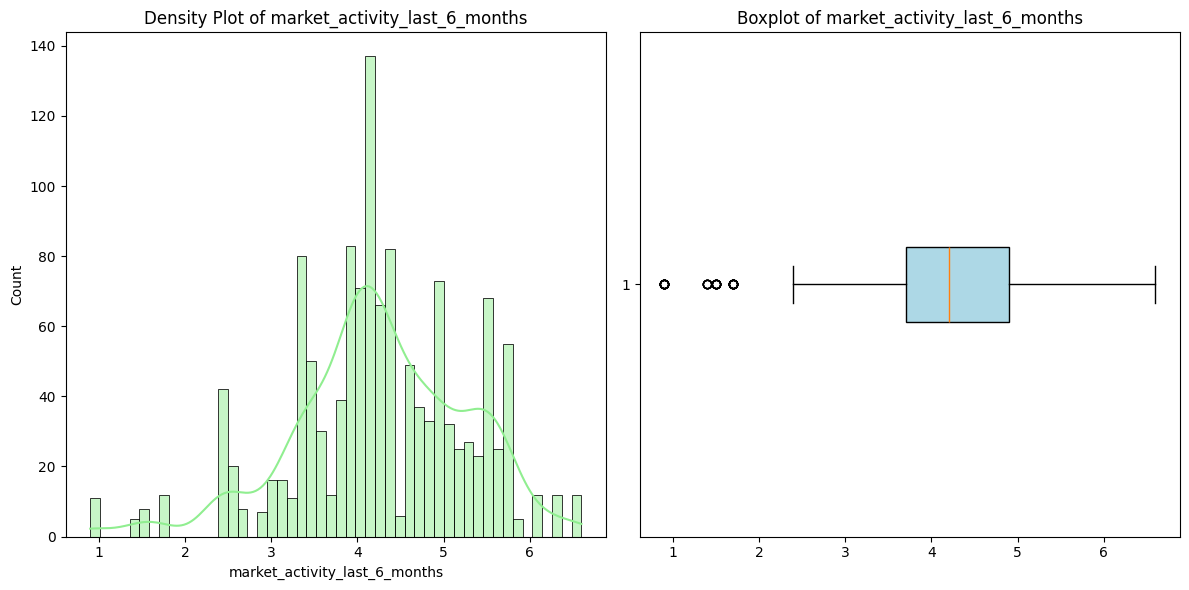

None


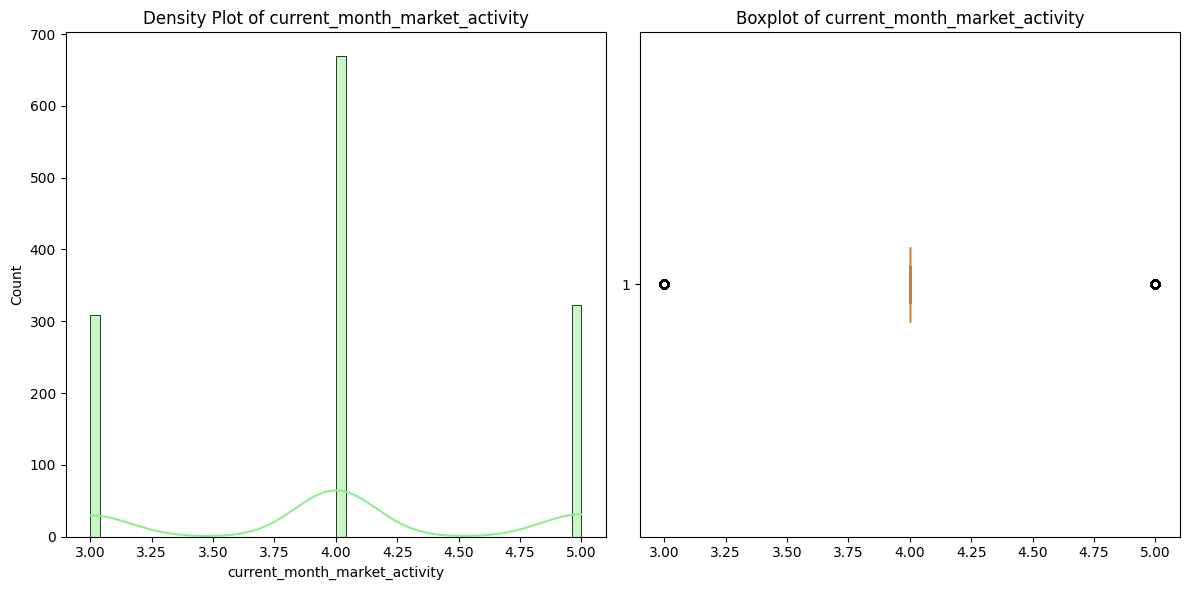

None


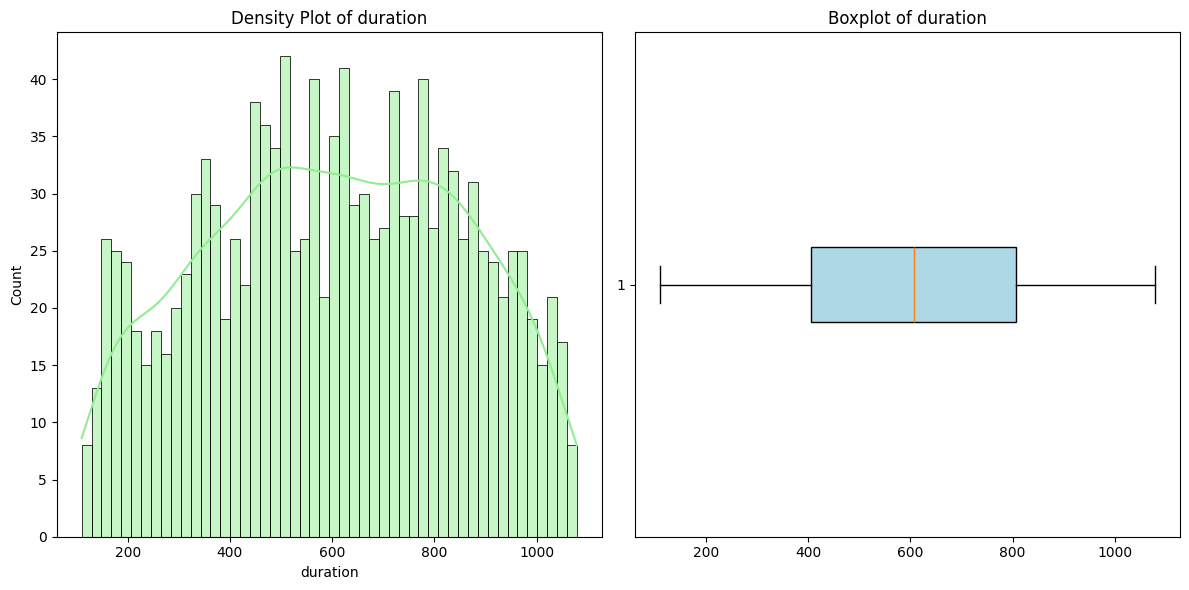

None


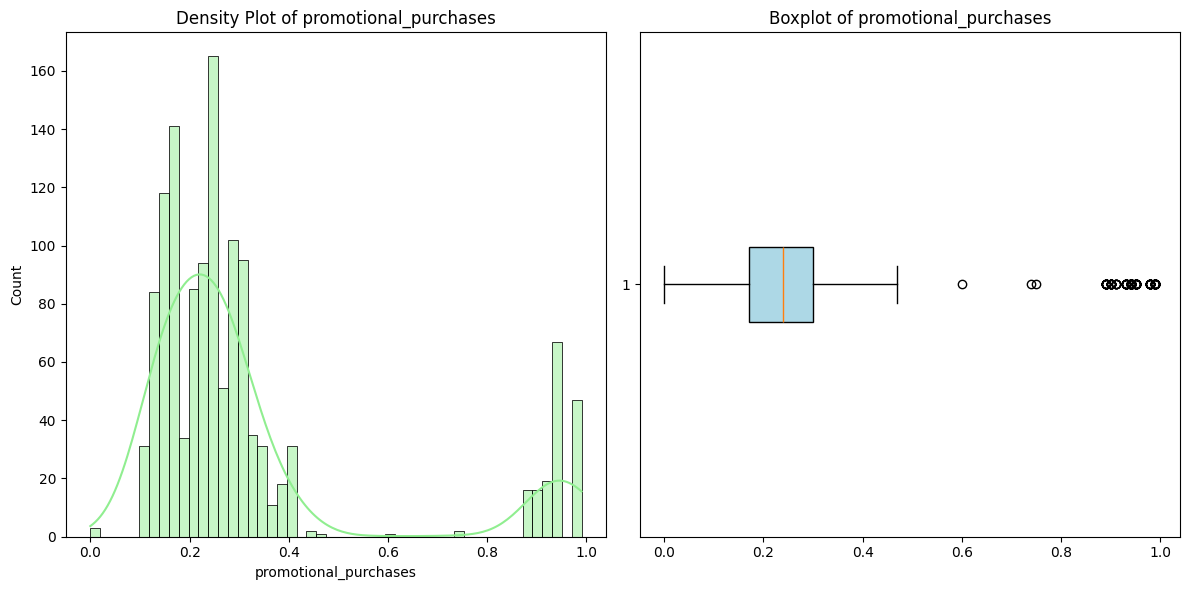

None


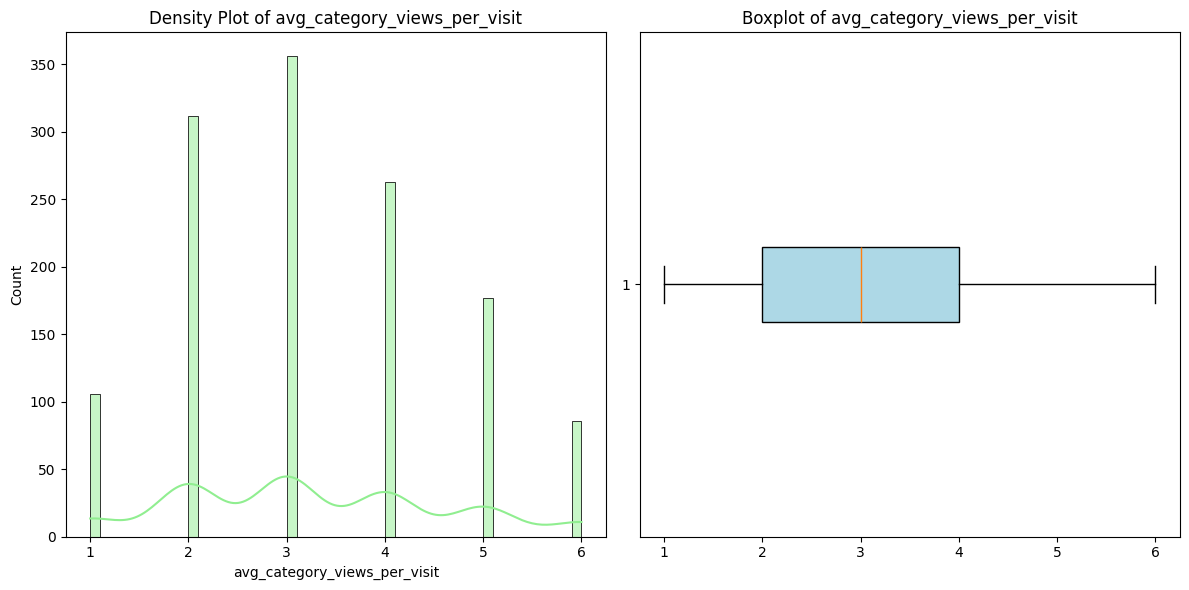

None


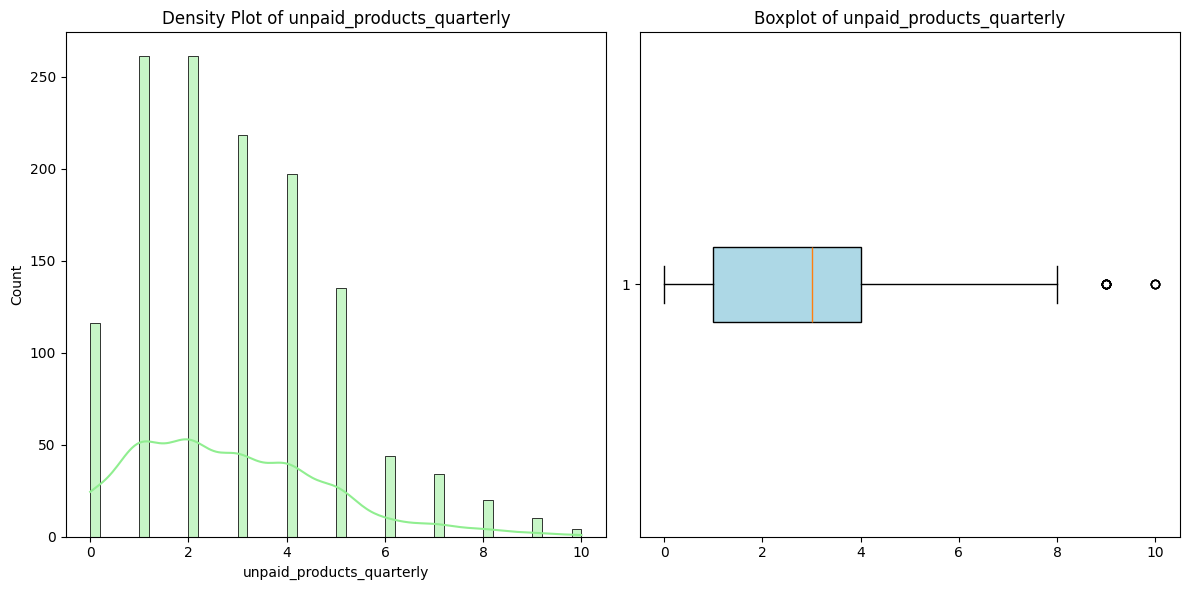

None


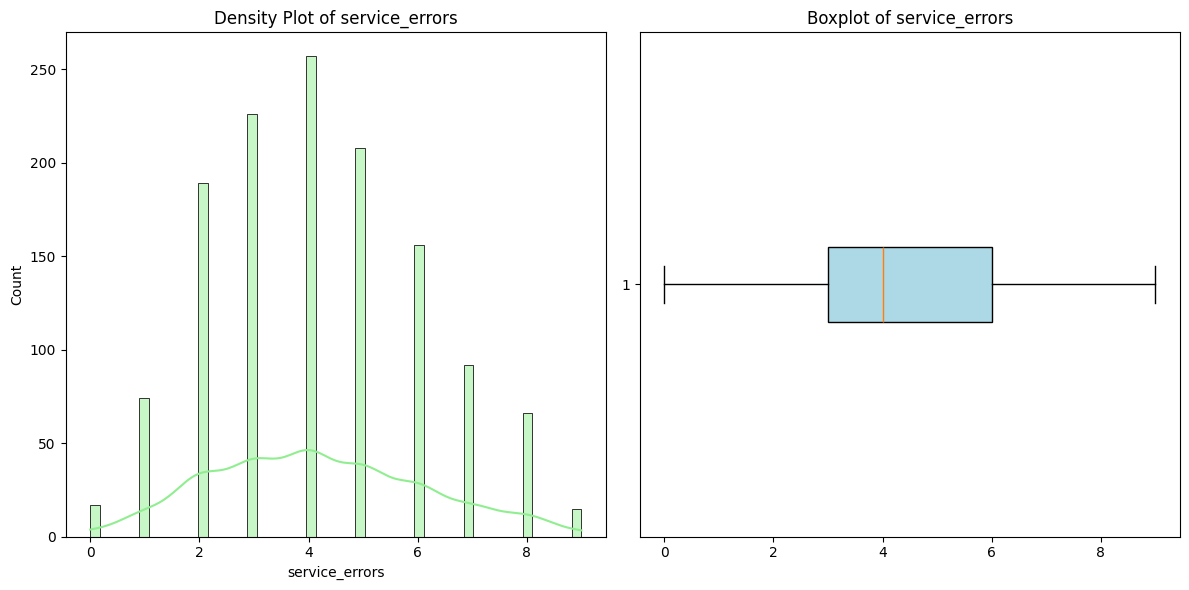

None


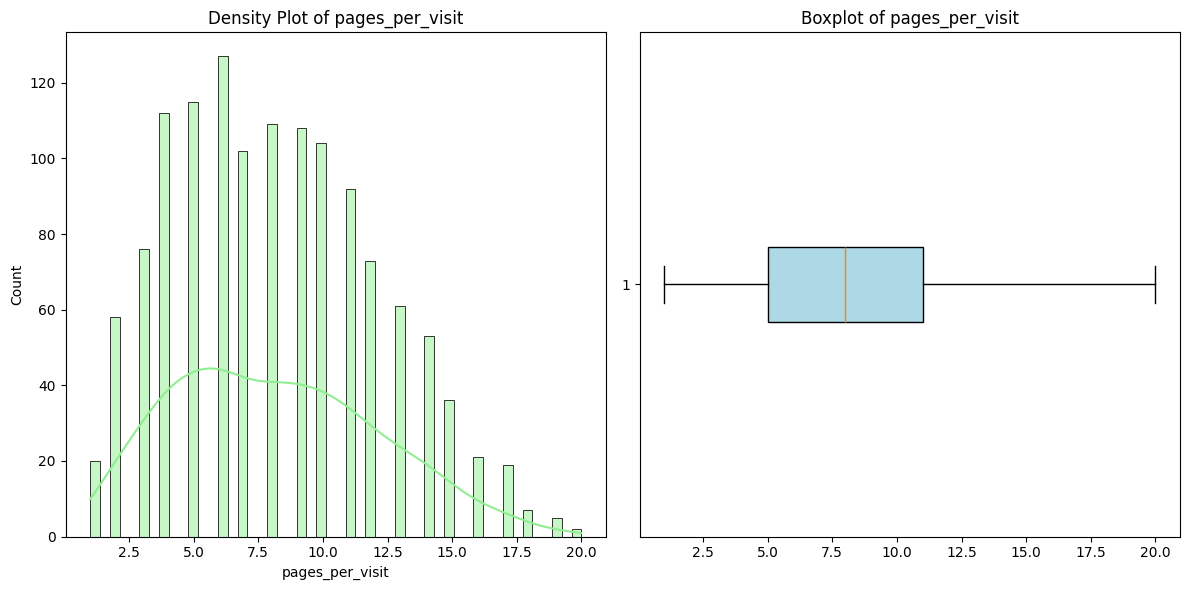

None


In [22]:
for col in _num.columns:
    print(plot_density_and_boxplot(_num, col))

Выводы:
- Среднемесячное значение маркетинговых коммуникаций компании: распределение напоминает нормальное, боксплот показывает некие выбросы, однако, нельзя утверждать, что данные значения являются аномалиями.
- Количество маркетинговых коммуникаций в текущем месяце: при таком масштабе прослеживается три категории, вероятно, необходимо будет данный признак преобразовать в категориальный, либо сгладится масштабированием.
- Длительность распределена равномерно.
- Среднемесячная доля покупок по акции: распределение бимодальное. Вероятно, необходимо будет перевести данный признак в категориальный.
- Средний просмотр категорий за визит: распределение не симметричное - скошено вправо.
- Общее число неоплаченных товаров в корзине за последние 3 месяца: распределение не симметричное, скошено вправо, т.к. присутствуют пользователи, у которых более 8-ти позиций в корзине, что также указано на боксплоте выбросы. Однако, нельзя с полной уверенностью считать эти значения аномальными.
- Ошибка сервиса: число сбоев для одного покупателя в районе 4-х. Распределение более или менее симметричное, аномалий нет.
- Количество страниц за один визит:распределение не симметричное - скошено вправо.

##### 1.1.2.2 Категориальные признаки

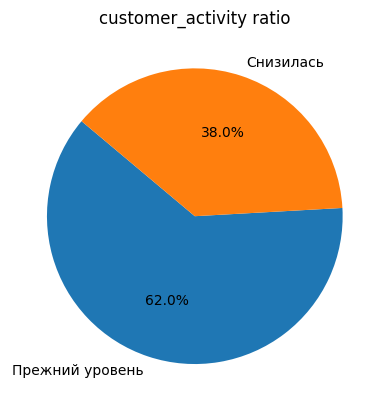

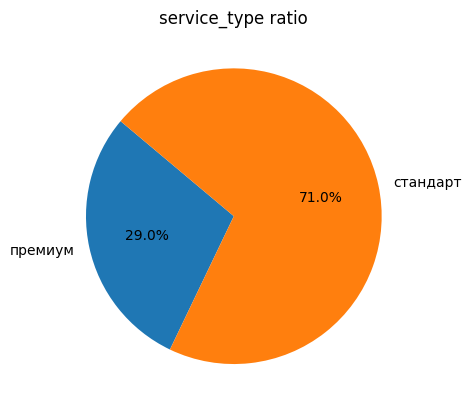

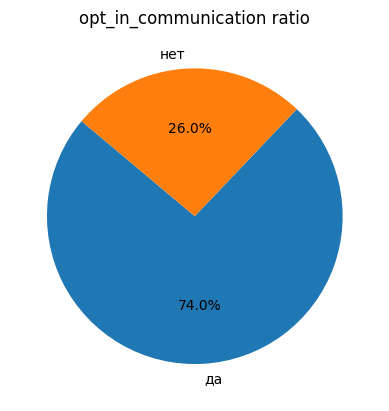

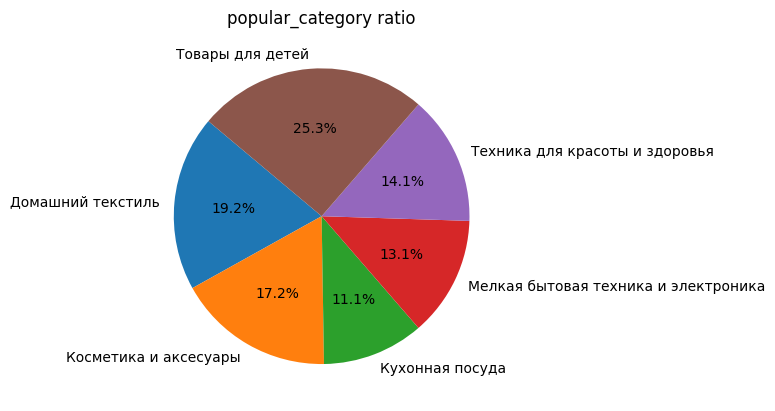

In [23]:
for col in customer[non_numeric(customer)]:
    plot_pie_chart(customer, col)

Выводы:
- Таргет: наблюдается дисбаланс классов. Мажорный класс больше минорного на 24 процентных пункта. Вероятно, необходимо будет произвести стратификацию или ресемплинг.  
- Признаки тип сервиса и "разрешать сообщать" содержат два класса, а популярная категория шесть, что необходимо учесть при кодировании.

### 1.2. Данные о тратах Клиентов

#### 1.2.1 Первичный анализ и предобработка

In [24]:
main_info(customer_expenditure)


DataFrame Shape:

Число наблюдений: 3900

Число признаков: 3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

DataFrame Head:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


Percentage of Missing values:


id        0.00
Период    0.00
Выручка   0.00
dtype: float64

Duplicates:


0

In [25]:
customer_expenditure[['id','Период']].duplicated().sum()

0

In [26]:
# Приведение названий к удобному виду
customer_expenditure = customer_expenditure.rename(columns={
    'Период': 'period',
    'Выручка': 'expenditure'
})

In [27]:
customer_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3900 non-null   int64  
 1   period       3900 non-null   object 
 2   expenditure  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Выводы:
- 2 потенциальных признака, влияющих на Таргет (количественный и категориальный).
- Типы данных указаны корректно.
- Пропусков в данных не обнаружено.
- Полных дубликатов не обнаружено.
- Дубликатов первичного ключа не выявлено.

#### 1.2.2 Cтатистический анализ

In [28]:
customer_expenditure.groupby('period')['expenditure'].describe().T

period,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,"1,300.00","1,300.00","1,300.00"
mean,"4,936.92","4,825.21","5,314.96"
std,739.60,405.98,"2,939.71"
min,0.00,0.00,"2,758.70"
25%,"4,496.75","4,583.00","4,706.05"
50%,"5,005.00","4,809.00","5,179.95"
75%,"5,405.62","5,053.50","5,761.73"
max,"6,869.50","5,663.00","106,862.20"


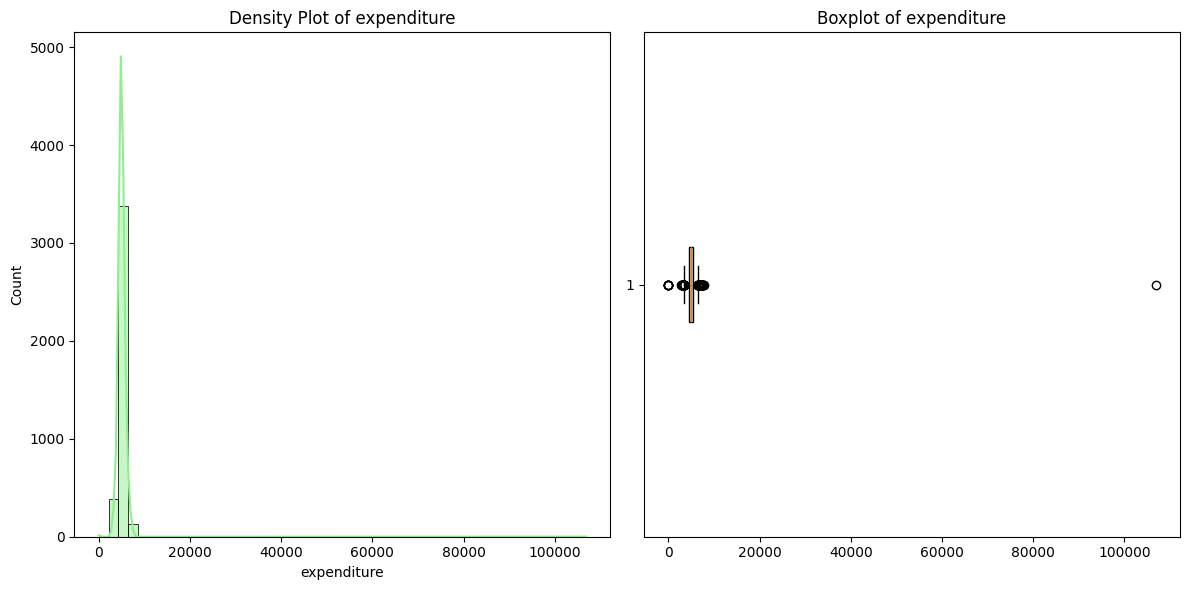

In [29]:
plot_density_and_boxplot(customer_expenditure, 'expenditure')

In [30]:
_f = customer_expenditure['expenditure'] > 100000
customer_expenditure[_f]

,id,period,expenditure
98,215380,текущий_месяц,"106,862.20"


Вероятно, одиночное значение 106,862.20 справа на боксплоте - это аномалия. Уберём информацию по пользователю, где присутствует этот выброс.

In [31]:
_f = customer_expenditure['id'] != 215380
customer_expenditure = customer_expenditure[_f]
customer_expenditure[['expenditure']].describe()

,expenditure
count,"3,897.00"
mean,"4,999.29"
std,706.97
min,0.00
25%,"4,590.00"
50%,"4,956.00"
75%,"5,363.00"
max,"7,799.40"


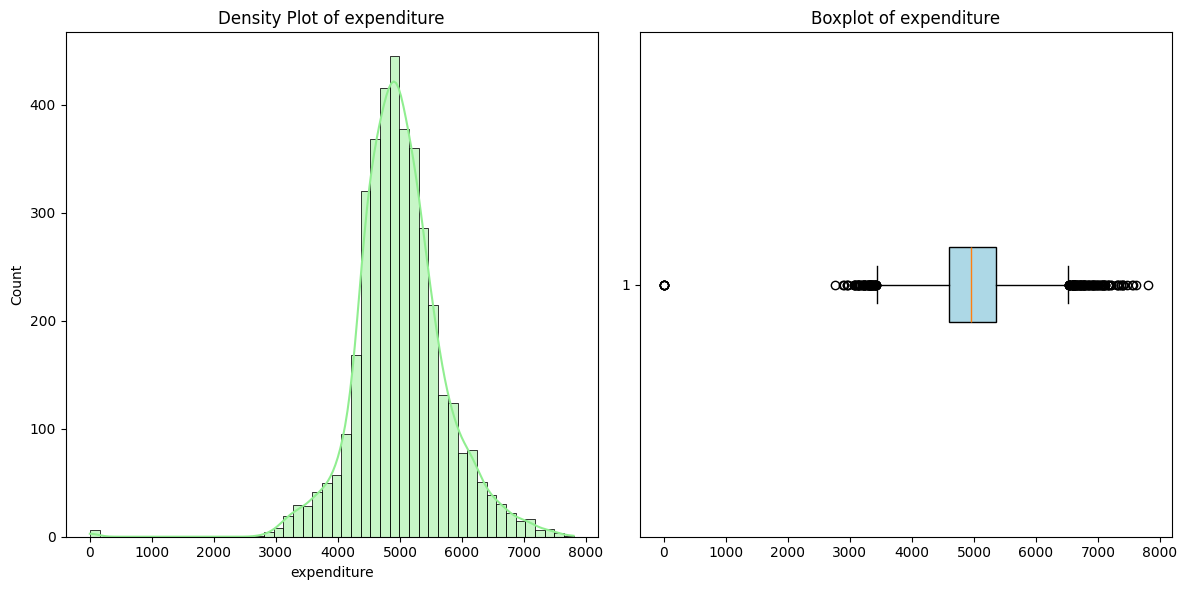

In [32]:
plot_density_and_boxplot(customer_expenditure, 'expenditure')

Выводы:
- Среднее значение (4,999.58) и медиана (4,956.00) находятся довольно близко друг к другу, что говорит о том, что данные относительно симметричны.
- Средняя выручка с Клиентов составляет 4,999.58 +- 706.97.
- Минимальное значение выручки равно 0.00, т.к., есть пользователи, которые не приобретали ничего в два предыдущих месяца.
- Число наблюдений по каждому периоду одинаковое.

### 1.3. Данные о времени Клиентов на сайте

#### 1.3.1 Первичный анализ и предобработка

In [33]:
main_info(customer_time)


DataFrame Shape:

Число наблюдений: 2600

Число признаков: 3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

DataFrame Head:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Percentage of Missing values:


id       0.00
Период   0.00
минут    0.00
dtype: float64

Duplicates:


0

In [34]:
customer_time[['id','Период']].duplicated().sum()

0

In [35]:
# Исправление опечатки в названии класса
customer_time['Период'] = customer_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
customer_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [36]:
# Приведение названий к удобному виду
customer_time = customer_time.rename(columns={
    'Период': 'period',
    'минут': 'time_min'
})

Выводы:
- 2 потенциальных признака, влияющих на Таргет (количественный и категориальный).
- Типы данных указаны корректно.
- Пропусков в данных не обнаружено.
- Полных дубликатов не обнаружено.
- Дубликатов первичного ключа не выявлено.

#### 1.3.2 Cтатистический анализ

In [37]:
customer_time.groupby('period')[['time_min']].describe().T

period          предыдущий_месяц  текущий_месяц
time_min count          1,300.00       1,300.00
         mean              13.47          13.20
         std                3.93           4.22
         min                5.00           4.00
         25%               11.00          10.00
         50%               13.00          13.00
         75%               17.00          16.00
         max               23.00          23.00

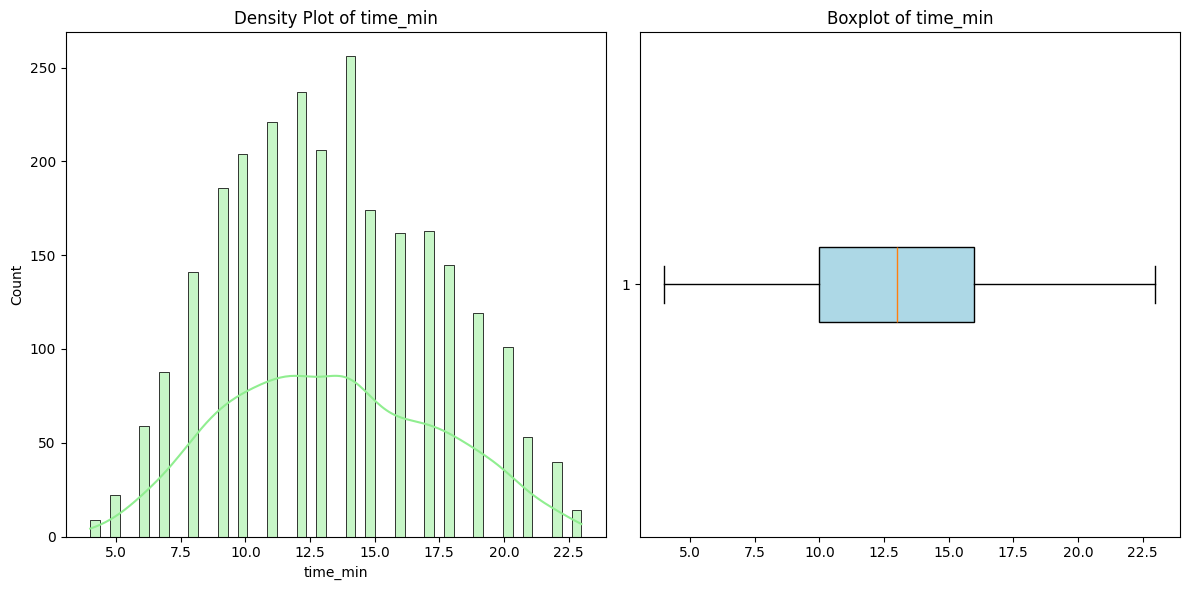

In [38]:
plot_density_and_boxplot(customer_time, 'time_min')

Выводы:
- Представлены данные только за два периода, в отличие от датасета с выручкой.
- Количество наблюдений каждого класса одинаковое.
- Данные распеределены довольно таки равномерно, причем по обоим периодам.
- Среднее время на сайте составляет примерно 13 минут.
- Выбросов, аномалий нет.

### 1.4. Данные о прибыли Заказчика

#### 1.4.1 Первичный анализ и предобработка

In [39]:
main_info(customer_profit)


DataFrame Shape:

Число наблюдений: 1300

Число признаков: 2

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

DataFrame Head:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Percentage of Missing values:


id        0.00
Прибыль   0.00
dtype: float64

Duplicates:


0

In [40]:
customer_profit['id'].duplicated().sum()

0

In [41]:
customer_profit = customer_profit.rename(columns={
    'Прибыль': 'profit'
})

In [42]:
customer_profit.head()

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Выводы:
- 1 потенциальный признак, влияющий на Таргет (количественный).
- Пропусков в данных не обнаружено.
- Полных дубликатов не обнаружено.
- Дубликатов первичного ключа не выявлено.
- Откорректирован тип данных в столбце "Прибыль".
- Не ясна **размерность** прибыли. Возможно, точка стоит не в том месте.

In [43]:
customer_expenditure[customer_expenditure['id']==215348]

,id,period,expenditure
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00


In [44]:
customer_profit[customer_profit['id']==215348]

,id,profit
0,215348,0.98


- Нет уверенности, как именно формировалась прибыль, поэтому данный признак пока нет возможности откорректировать. Возможно, при масштабировании признаков в дальнейшем данная проблема будет решена.

#### 1.4.2 Cтатистический анализ

In [45]:
customer_profit[['profit']].describe()

,profit
count,"1,300.00"
mean,4.00
std,1.01
min,0.86
25%,3.30
50%,4.04
75%,4.67
max,7.43


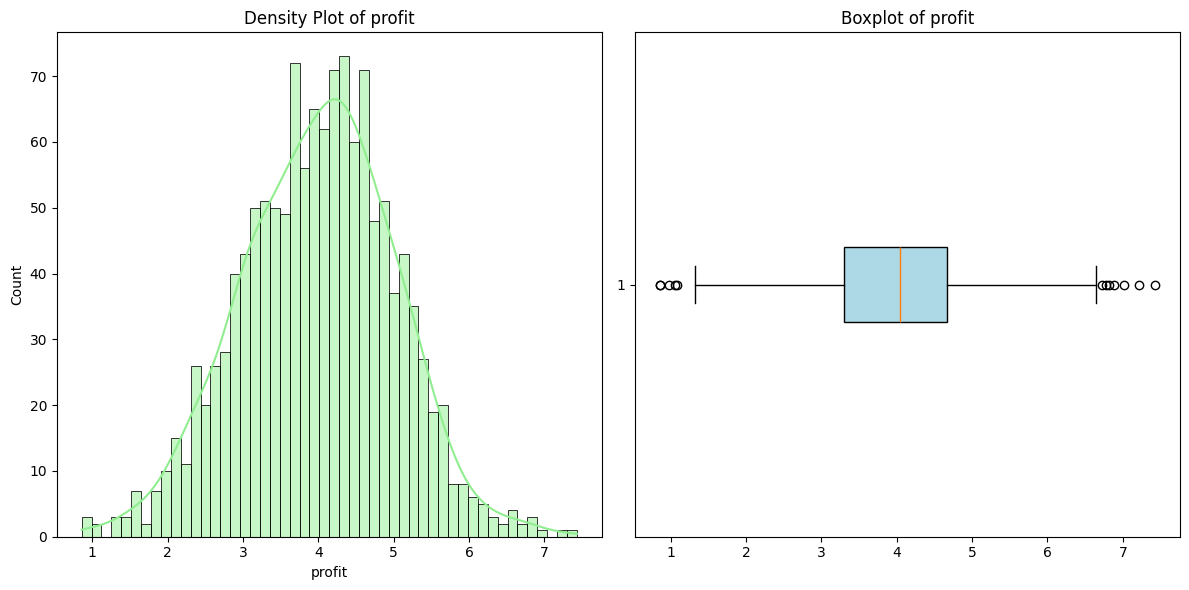

In [46]:
plot_density_and_boxplot(customer_profit, 'profit')

Выводы:
- Несмотря на неясности в размерности данных, значения признака распределены равномерно и симметрично.
- Явных аномалий нет.


## 2. Отбор активных пользователей
Необходимо отобрать пользователей с покупательской активностью не менее трёх месяцев. 

In [47]:
# Информация по выручке за 3 месяца
customer_expenditure.head()

,id,period,expenditure
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


In [48]:
# Отбор id пользователей, у которых не было трат в предыдущем и предпредыдущем месяце
_f1 = (customer_expenditure['period']=='препредыдущий_месяц') | (customer_expenditure['period']=='предыдущий_месяц')
_f2 = customer_expenditure['expenditure']==0

In [49]:
# Список id пользователей, которых необходимо исключить из анализа
list_of_ids = customer_expenditure['id'][_f1 & _f2].unique().tolist()
list_of_ids

[215348, 215357, 215359]

In [50]:
# Функция для сортировки датасетов
def df_filtered(df, list_of_ids):
    df_new = df[~df['id'].isin(list_of_ids)] 
    print('Число наблюдений до отбора:', df.shape[0])
    print('Число наблюдений после отбора:', df_new.shape[0])
    return df_new

In [51]:
# Информация о пользователях
customer_filtered = df_filtered(customer, list_of_ids)

Число наблюдений до отбора: 1300
Число наблюдений после отбора: 1297


In [52]:
# Траты пользователей
customer_expenditure_filtered = df_filtered(customer_expenditure, list_of_ids)

Число наблюдений до отбора: 3897
Число наблюдений после отбора: 3888


In [53]:
# Время на сайте
customer_time_filtered = df_filtered(customer_time, list_of_ids)

Число наблюдений до отбора: 2600
Число наблюдений после отбора: 2594


In [54]:
# Прибыль
customer_profit_filtered = df_filtered(customer_profit, list_of_ids)

Число наблюдений до отбора: 1300
Число наблюдений после отбора: 1297


## 3. Объединение датасетов

- Объединение таблиц market_file.csv, market_money.csv, market_time.csv. 
- По ТЗ данные о прибыли при моделировании не использовать. 

In [55]:
customer_expenditure_filtered.head()

,id,period,expenditure
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"
5,215349,предыдущий_месяц,"5,216.00"
6,215350,препредыдущий_месяц,"4,826.00"
7,215350,текущий_месяц,"5,058.40"


In [56]:
# Поворот датафрейма
customer_expenditure_pivot = customer_expenditure_filtered.pivot(index='id', columns='period', values='expenditure')
customer_expenditure_pivot.columns = [
    'expenditure_previous_month', 
    'expenditure_pre_previous_month', 
    'expenditure_current_month'
]
customer_expenditure_pivot = customer_expenditure_pivot.reset_index()


In [57]:
customer_expenditure_pivot.head()

,id,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month
0,215349,"5,216.00","4,472.00","4,971.60"
1,215350,"5,457.50","4,826.00","5,058.40"
2,215351,"6,158.00","4,793.00","6,610.40"
3,215352,"5,807.50","4,594.00","5,872.50"
4,215353,"4,738.50","5,124.00","5,388.50"


In [58]:
customer_filtered.shape

(1297, 13)

In [59]:
customer_expenditure_pivot.shape

(1296, 4)

In [60]:
# Объединение двух первых датасетов. 
# Ориентир по количеству строк - датасет с выручкой (т.к. в нем был удалён id с выбросом)
_df_merged = customer_filtered.merge(customer_expenditure_pivot, on='id')
_df_merged.head()

,id,customer_activity,service_type,opt_in_communication,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,popular_category,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60"
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40"
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40"
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50"
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50"


In [61]:
# Третий датасет
customer_time_filtered.head()

,id,period,time_min
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


In [62]:
# Поворот датасета
customer_time_pivot = customer_time_filtered.pivot(index='id', columns='period', values='time_min')
customer_time_pivot.columns = [
    'time_previous_month_min',
    'time_current_month_min'
]
customer_time_pivot = customer_time_pivot.reset_index()

In [63]:
customer_time_pivot.head()

,id,time_previous_month_min,time_current_month_min
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [64]:
customer_time_pivot.shape

(1297, 3)

In [65]:
# Итоговое объединение
df_merged = _df_merged.merge(customer_time_pivot, on='id')
df_merged.head()

,id,customer_activity,service_type,opt_in_communication,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,popular_category,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month,time_previous_month_min,time_current_month_min
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12,10
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40",8,13
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40",11,13
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50",8,11
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50",10,10


In [66]:
# Проверка объединения
print(f'Original dataframe (Customer expenditure pivot) shape: {customer_expenditure_pivot.shape}')
print(f'Customer filtered dataframe shape: {customer_filtered.shape}')
print(f'Customer time pivot shape: {customer_time_pivot.shape}')
print(f'Merged dataframe shape: {df_merged.shape}')

# Проверка по числу строк
if df_merged.shape[0] == customer_expenditure_pivot.shape[0]:
    print('Merge successful: All rows from the original dataframe are retained in the merged dataframe.')
else:
    print('Error while merging: Number of rows in the merged dataframe does not match the original.')

# Проверка на дубликаты
if df_merged.duplicated().sum() > 0:
    print(f'Duplicates detected in the merged dataframe: {df_merged.duplicated().sum()} duplicates found.')
else:
    print('No duplicates in the merged dataframe.')

# Проверка на дубликаты по первичному ключу 'id'
if df_merged['id'].duplicated().sum() > 0:
    print(f'Primary keys duplicates detected: {df_merged["id"].duplicated().sum()} duplicates found.')
else:
    print('No duplicates in primary keys.')

Original dataframe (Customer expenditure pivot) shape: (1296, 4)
Customer filtered dataframe shape: (1297, 13)
Customer time pivot shape: (1297, 3)
Merged dataframe shape: (1296, 18)
Merge successful: All rows from the original dataframe are retained in the merged dataframe.
No duplicates in the merged dataframe.
No duplicates in primary keys.


## 4. Корреляционный анализ

In [67]:
# Матрица корреляции признаков в количественной шкале итогового датафрейма
matrix = df_merged[numeric(df_merged)].drop('id', axis=1)
matrix = matrix.phik_matrix(interval_cols=numeric(df_merged))

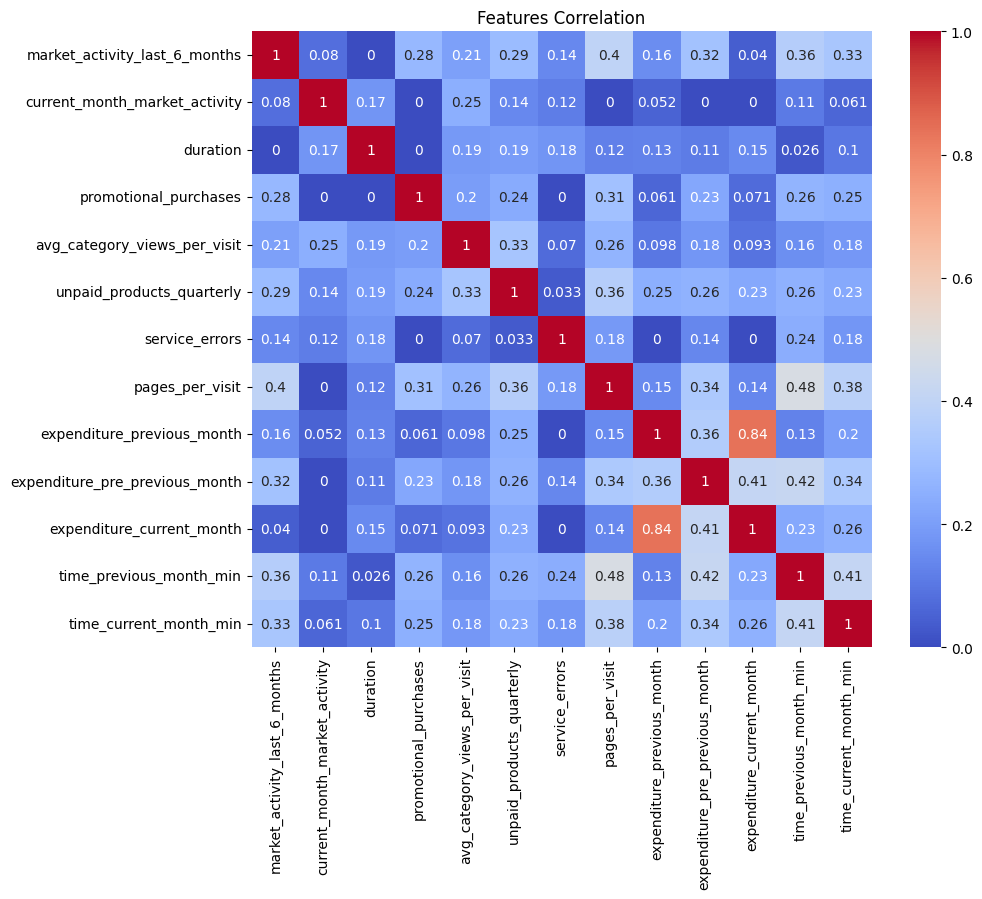

In [68]:
# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Features Correlation')
plt.show()

Сильная линейная связь (|корр.|=0.9-0.95) входных признаков не прослеживается.

## 5. Создание моделей МО

### 5.1. Подготовка финального датасета

In [69]:
# Объединённый датасет
df_merged.head()

,id,customer_activity,service_type,opt_in_communication,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,popular_category,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month,time_previous_month_min,time_current_month_min
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12,10
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40",8,13
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40",11,13
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50",8,11
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50",10,10


In [70]:
# Итоговый датафрейм для модели
df_final = df_merged.set_index('id')
df_final.head()

,customer_activity,service_type,opt_in_communication,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,popular_category,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month,time_previous_month_min,time_current_month_min
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12,10
215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40",8,13
215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40",11,13
215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50",8,11
215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50",10,10


In [71]:
# Число наблюдений и число признаков
df_final.shape

(1296, 17)

### 5.2. Подготовка данных к моделированию

In [72]:
# Отделение признаков
X = df_final.drop('customer_activity', axis=1)
y = df_final['customer_activity']

In [73]:
# Кодирование таргета (1 - снизилась, 0 - прежний уровень)
original_classes = ['Снизилась', 'Прежний уровень']

le = LabelEncoder()
le.classes = np.array(original_classes)

y = le.fit_transform(y)

In [74]:
# Разделение на выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y) # стратификация для сохранения пропорции мажорного и минорного классов

In [75]:
# Проверка размера выборок
X_train.shape, X_val.shape

((1036, 16), (260, 16))

- Подготовка признаков для кодирования/масштабирования.

In [76]:
for col in non_numeric(df_final):
    print(col, df_final[col].unique())

customer_activity ['Снизилась' 'Прежний уровень']
service_type ['премиум' 'стандарт']
opt_in_communication ['да' 'нет']
popular_category ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника']


In [77]:
# Категориальные признаки с ранжированием
cat_ranged = ['service_type']

# Категориальные признаки без ранжирования
cat_non_ranged = ['opt_in_communication', 'popular_category']

# Числовые
num = numeric(df_final)

In [78]:
# Проверка, что все входные признаки учтены
assert len(cat_non_ranged) + len(cat_ranged) + len(num) == X_train.shape[1], "Не все признаки учтены!"

### 5.3. Создание пайплайнов для подготовки признаков

In [79]:
# Пайплайн для кодирования признаков без ранжирования

ohe_encoder_pipe = Pipeline(
    [
        ('imputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [80]:
# Пайплайн для кодирования признаков с ранжированием

ord_encoder_pipe = Pipeline(
    [
        ('imputer_initial', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['премиум', 'стандарт']],
                               handle_unknown='use_encoded_value', 
                               unknown_value=np.nan)),
        ('imputer_post', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [81]:
# Пайплайн для подготовки признаков
features_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_encoder_pipe, cat_non_ranged),
        ('ord', ord_encoder_pipe, cat_ranged),
        ('num', StandardScaler(), num)
    ]
)

In [82]:
# Пайплайн, включающий подготовку данных и модель
customer_activity_pipe = Pipeline([
        ('preprocessor', features_preprocessor),
        ('model', LogisticRegression())
])

### 5.4. Первичная модель

- В качестве первичной модели используется логистическая регрессия (с нормализаций количественных признаков методом StandardScaler()).
- Обучим модель, сделаем прогнозы на валидационной выборке и посмотрим метрики.

In [83]:
# Обучение модели
customer_activity_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in_communication',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_initial',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                  ['market_activity_last_6_months',
                                                   'current_month_market_activity',
                                                   'duration',
                                                   'promotional_purchases',
                                                   'avg_category_views_per_visit',
                                                   'unpaid_products_quarterly',
                                                   'service_errors',
                                                   'pages_per_visit',
                                                   'expenditure_previous_month',
                                                   'expenditure_pre_previous_month',
                                                   'expenditure_current_month',
                                                   'time_previous_month_min',
                                                   'time_current_month_min'])])),
                ('model', LogisticRegression())])

In [84]:
# Прогнозирование
y_pred = customer_activity_pipe.predict(X_val)

In [85]:
# Расчёт метрик качества модели (accuracy, recall, precision)
acc_init = accuracy_score(y_val, y_pred)
precision_init = precision_score(y_val, y_pred)
recall_init = recall_score(y_val, y_pred)

print("Accuracy:", acc_init)
print("Precision", precision_init)
print("Recall:", recall_init)

Accuracy: 0.9
Precision 0.9010989010989011
Recall: 0.8282828282828283


**Accuracy** показывает, что верными являются 90% предсказаний.

**Precision** показывает, точность, с которой модель присваивает объектам класс 1 (т.е. что активность 'снизилась'), т.е. в 90% случаев модель правильно предсказывает этот класс, в 10% модель присваивает класс 1 ('снизилась') категории 'прежний уровень'.

**Recall** показывает долю правильно предсказанного класса "снизилась" от общего количества признаков имеющих в действительности класс "снизилась", т.е. при сниженной активности в 83% случаев модель присваивает класс "снизилась", а в 17% модель присваивает класс "прежний уровень".

Модель неплохо себя показала при вышеуказанных параметрах. Однако, необходимо попробовать другие модели и выбрать оптимальную.

### 5.5. Подбор моделей

Учитывая, что Заказчик хочет удерживать активность постоянных клиентов, и требуется предсказать вероятность снижения покупательской активности Клиента, важно не пропустить статус 'снизилась', поэтому стоит сосредоточиться на метрике **Recall**.

Необходимо перебрать различные модели (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()), а также различные их гиперпараметры для поиска наилучших параметров.

In [86]:
# Параметрическая сетка для GridSearchCV

param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 6),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2,5),
        'model__min_samples_split': range(2,5),
        'model__min_samples_leaf': range(1, 5),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [SVC(random_state=RANDOM_STATE)],
        'model__C': range(1, 5),
        'model__kernel': ['linear', 'poly'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]

- В качестве первоначального способа поиска используем случайный поиск, т.к. он быстрее.

In [87]:
# Запуск случайного поиска
random_search = RandomizedSearchCV(
    customer_activity_pipe,
    param_distributions=param_grid,
    cv=5,
    scoring='recall',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [88]:
# Обучение модели
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['opt_in_communication',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer_initial',
                                                                                                Simp...
                                        {'model': [LogisticRegression(penalty='l1',
                                                                      random_state=42,
                                                                      solver='liblinear')],
                                         'model__C': range(1, 5),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               'passthrough']},
                                        {'model': [SVC(random_state=42)],
                                         'model__C': range(1, 5),
                                         'model__kernel': ['linear', 'poly'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='recall')

In [89]:
# Лучшая модель по результатам случайного поиска
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in_communication',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_initial',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                   'current_month_market_activity',
                                                   'duration',
                                                   'promotional_purchases',
                                                   'avg_category_views_per_visit',
                                                   'unpaid_products_quarterly',
                                                   'service_errors',
                                                   'pages_per_visit',
                                                   'expenditure_previous_month',
                                                   'expenditure_pre_previous_month',
                                                   'expenditure_current_month',
                                                   'time_previous_month_min',
                                                   'time_current_month_min'])])),
                ('model', KNeighborsClassifier(n_neighbors=3))])

In [90]:
# Наиболее удачное сочетание гиперпараметров лучшей модели 
random_search.best_params_

{'preprocessor__num': StandardScaler(),
 'model__n_neighbors': 3,
 'model': KNeighborsClassifier()}

In [91]:
# Самый высокий показатель метрики на тренировочных данных
random_search.best_score_

0.7569620253164556

По результатам выполнения случайного поиска выбран алгоритм "Метод K-ближайших соседей". Его гиперпараметры:
- число ближайших образцов (соседей) k = 3,
- метрика recall на тренировочных данных 0.76.
- предобработка - масштабирование числовых признаков c помощью стандартизации,

Проверим метрику на валидационной выборке.

In [92]:
y_pred = random_search.predict(X_val)

In [93]:
recall_rand = recall_score(y_val, y_pred)
print(f'Initial Recall (valid): {recall_init}')
print(f'Random Search Recall (valid): {recall_rand}')

Initial Recall (valid): 0.8282828282828283
Random Search Recall (valid): 0.8080808080808081


Метрика recall ниже, чем при первоначальной модели. Вероятно, случайный поиск перебрал не достаточно комбинаций.

Необходимо проверить поиском по сетке.

In [94]:
# Запуск поиска по сетке
grid_search = GridSearchCV(
    customer_activity_pipe,
    param_grid=param_grid,
    scoring='recall',
    n_jobs=-1
)

In [95]:
# Обучение
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['opt_in_communication',
                                                                          'popular_category']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('imputer_initial',
                                                                                          SimpleImputer(s...
                                                'passthrough']},
                         {'model': [LogisticRegression(penalty='l1',
                                                       random_state=42,
                                                       solver='liblinear')],
                          'model__C': range(1, 5),
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                'passthrough']},
                         {'model': [SVC(random_state=42)],
                          'model__C': range(1, 5),
                          'model__kernel': ['linear', 'poly'],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                'passthrough']}],
             scoring='recall')

In [96]:
# Лучшая модель
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in_communication',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_initial',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                   'duration',
                                                   'promotional_purchases',
                                                   'avg_category_views_per_visit',
                                                   'unpaid_products_quarterly',
                                                   'service_errors',
                                                   'pages_per_visit',
                                                   'expenditure_previous_month',
                                                   'expenditure_pre_previous_month',
                                                   'expenditure_current_month',
                                                   'time_previous_month_min',
                                                   'time_current_month_min'])])),
                ('model',
                 LogisticRegression(C=2, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [97]:
# Оптимальные гиперпараметры
grid_search.best_params_

{'model': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
 'model__C': 2,
 'preprocessor__num': StandardScaler()}

По результатам выполнения поиска по сетке выбран алгоритм логистической регрессии. Его гиперпараметры:
- регуляризация l1 (лассо),
- сила регуляризации С = 2,
- предобработка - масштабирование числовых признаков c помощью стандартизации,

Проверим метрику на тренировочной и валидационной выборках.

In [98]:
# Сравнение показателей метрик на тренировочных данных
print(f'Random Search Recall (train): {random_search.best_score_}')
print(f'Grid Search Recall (train): {grid_search.best_score_}')

Random Search Recall (train): 0.7569620253164556
Grid Search Recall (train): 0.7670886075949366


- Линейная регрессия показывает себя лучше, чем KNN. 
- Проверим на валидационной выборке.

In [99]:
# Сравнение показателей метрик на валидационных выборках
y_pred = grid_search.predict(X_val)
recall_grid = recall_score(y_val, y_pred)

print(f'Initial Recall (valid): {recall_init}')
print(f'Grid Search Recall (valid): {recall_grid}')

Initial Recall (valid): 0.8282828282828283
Grid Search Recall (valid): 0.8282828282828283


- Логистическая регрессия показала себя одинаково как с дефолтными гиперпараметрами (l2, C=1), так и с гиперпараметрами подобраными поиском по сетке (l1, C=2).

При этом, отмечается, что метрика на валидационной выборке, превышает метрику на тренировочной выборке, чаще всего указывает на то, что модель не полностью захватила закономерности в данных. Желательно, добавить больше данных, чтобы помочь модели лучше понять закономерности и уменьшить недообучение.

Попробуем решить эту проблему с добавлением искусственных признаков.

In [100]:
# Пайплайн для числовых признаков с полиномизацией
num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

# Пайплайн для подготовки признаков
features_preprocessor_pol = ColumnTransformer(
    [
        ('ohe', ohe_encoder_pipe, cat_non_ranged),
        ('ord', ord_encoder_pipe, cat_ranged),
        ('num', num_pipeline, num)
    ]
)

# Пайплайн, включающий подготовку данных и модель
customer_activity_pipe_pol = Pipeline([
        ('preprocessor', features_preprocessor_pol),
        ('model', LogisticRegression())
])

In [101]:
# Выполнение GridSearchCV
search = GridSearchCV(
    customer_activity_pipe_pol,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

search.fit(X_train, y_train)

# Лучшие параметры и оценка
best_estimator = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

print("Best Estimator:", best_estimator)
print("Best Params:", best_params)
print("Best Score:", best_score)

# Обучение лучшей модели на тренировочной выборке
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

# Прогнозирование на валидационной выборке с использованием лучшей модели
y_pred = best_model.predict(X_val)

# Расчёт метрик на валидационной выборке
recall = recall_score(y_val, y_pred)
print("Validation Recall:", recall)

Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in_communication',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_initial',
                               

- Полиномизация признаков не улучшила метрику. Модель отобрана анлогичная предыдущим.
- Необходимо сообщить Заказчику, что в идеале необходимо предоставить дополнительные данные.

## 6. Анализ важности признаков

In [102]:
# Лучшая модель
model = grid_search.best_estimator_

In [103]:
# Подготовка данных для SHAP диаграммы
x_Train_transformed = customer_activity_pipe.named_steps['preprocessor'].fit_transform(X_train)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.LinearExplainer(model.named_steps['model'], x_Train_transformed, feature_names=feature_names)
shap_values = explainer(x_Train_transformed)

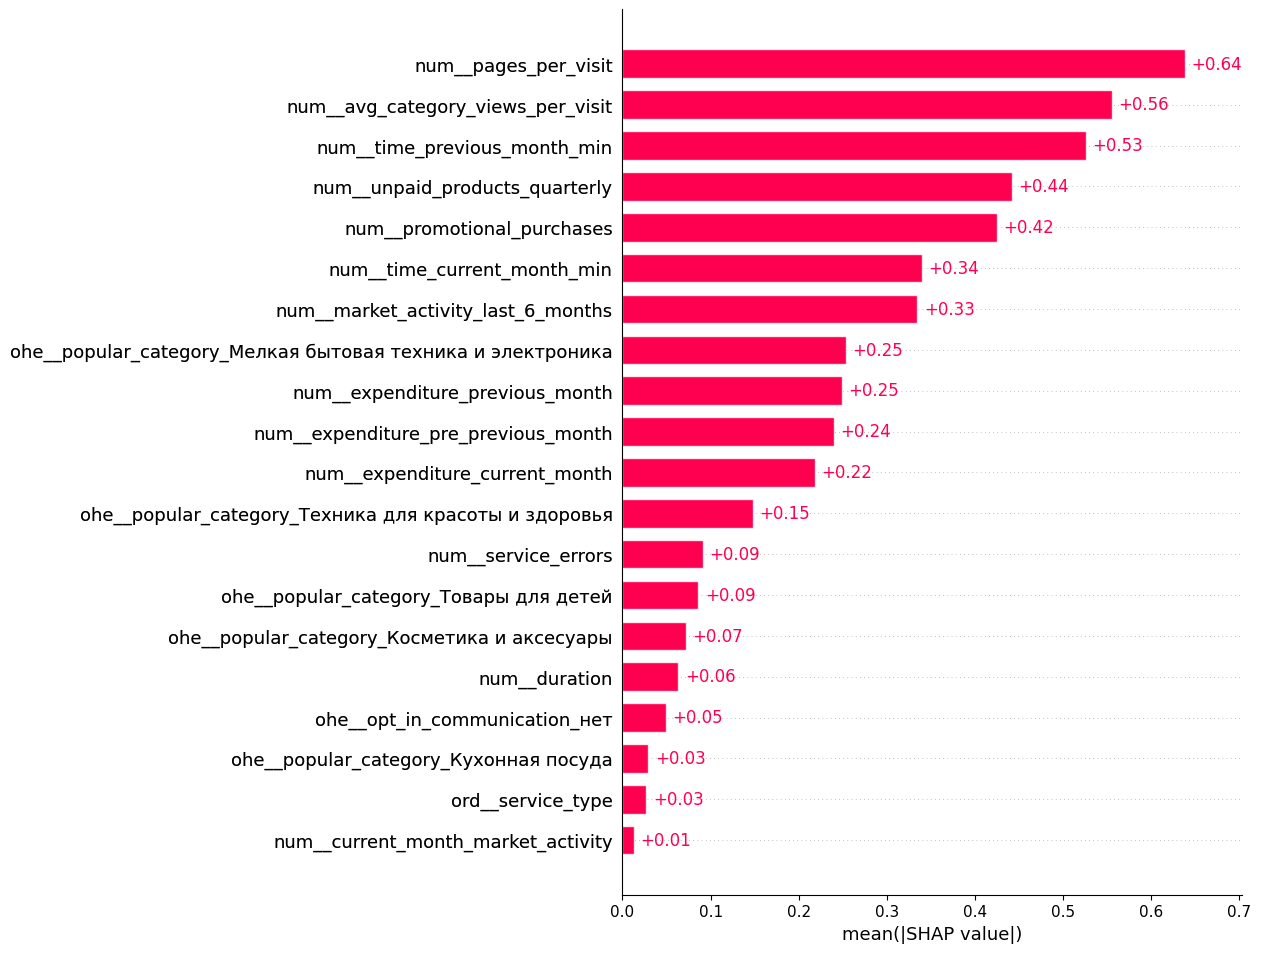

In [104]:
# Визуализация весомости признаков
feature_names = df_final.columns.tolist()
shap.plots.bar(shap_values, max_display=21) 

Вывод:
1. По результатам оценки средних SHAP‑значений каждого признака можно сделать вывод, что самый большой вес у признака, описывающего число страниц просмотренных пользователем за один визит на сайт магазина.
2. Также сильнее всего влияют на прогнозы модели следующие метрики (выделено 5 наиболее весомых):
- средний просмотр категорий за визит,
- время, проведённое на сайте за предыдущий месяц. Интересно, что время, проведённое на сайте в текущем месяце, меньше влияет на прогноз, вероятно, из-за того, что текущий месяц ещё не закончился, следовательно, количество минут в нём меньше, и модель видит этот признак как менее весомый.
- количество неоплаченных покупок в корзине.
- процент покупок по акции.
3. Признак, который модель расценивает как наименее значимый - активность пользователя в текущем месяце.

Необходимо посмотреть на данные признаки в разрезе прибыли. Данное исследование представлено в разделе 7.



## 7. Сегментация покупателей

In [105]:
# Массив с вероятностями
y_pred_proba = model.predict_proba(X_val)[:, 1]

In [106]:
# Добавление индексов
activity_predictions = pd.DataFrame({
    'id': X_val.index,
    'activity_decline_proba': y_pred_proba
})

In [107]:
activity_predictions.shape

(260, 2)

In [108]:
# Объединение с признаками
_activity_predictions = activity_predictions.merge(X_val, on='id')

In [109]:
_activity_predictions.shape

(260, 18)

In [110]:
# Объединение с прибылью
customer_full = _activity_predictions.merge(customer_profit, on='id')

In [111]:
customer_full.shape

(260, 19)

In [112]:
customer_full.head()

,id,activity_decline_proba,service_type,opt_in_communication,market_activity_last_6_months,current_month_market_activity,duration,promotional_purchases,popular_category,avg_category_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,expenditure_previous_month,expenditure_pre_previous_month,expenditure_current_month,time_previous_month_min,time_current_month_min,profit
0,215402,0.99,премиум,да,3.00,5,954,0.93,Товары для детей,3,2,4,6,"4,918.00","4,702.00","4,940.10",5,5,4.28
1,216035,0.09,премиум,нет,3.80,4,570,0.14,Товары для детей,2,1,2,13,"3,615.00","4,763.00","4,739.50",16,13,5.68
2,215701,1.00,стандарт,да,0.90,4,212,0.95,Домашний текстиль,2,5,4,2,"4,685.50","4,444.00","5,161.30",9,7,5.05
3,215860,0.03,стандарт,да,5.50,5,242,0.21,Кухонная посуда,5,4,4,11,"4,204.50","4,614.00","3,979.60",18,19,5.34
4,215761,0.02,стандарт,нет,5.70,4,565,0.14,Домашний текстиль,5,1,4,12,"4,252.00","5,023.00","3,713.80",12,18,2.60


In [113]:
# Фильтр по пяти самым весомым признакам
_list = ['id',
         'pages_per_visit', 
         'avg_category_views_per_visit', 
         'time_previous_month_min', 
         'unpaid_products_quarterly', 
         'promotional_purchases',
         'activity_decline_proba',
         'profit'
         ]

In [114]:
# Отфильтрованный датасет
customer_filtered = customer_full[_list]
customer_filtered

,id,pages_per_visit,avg_category_views_per_visit,time_previous_month_min,unpaid_products_quarterly,promotional_purchases,activity_decline_proba,profit
0,215402,6,3,5,2,0.93,0.99,4.28
1,216035,13,2,16,1,0.14,0.09,5.68
2,215701,2,2,9,5,0.95,1.00,5.05
3,215860,11,5,18,4,0.21,0.03,5.34
4,215761,12,5,12,1,0.14,0.02,2.60
...,...,...,...,...,...,...,...,...
255,215628,2,3,9,5,0.93,0.99,4.11
256,215590,4,5,12,8,0.29,0.85,4.14
257,216392,13,3,20,4,0.17,0.12,3.68
258,215948,5,3,12,0,0.18,0.18,4.60


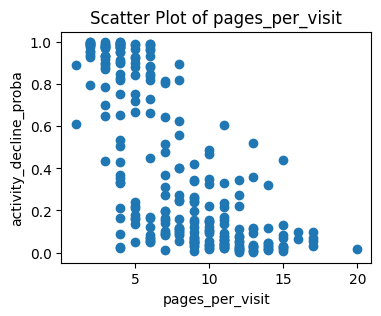

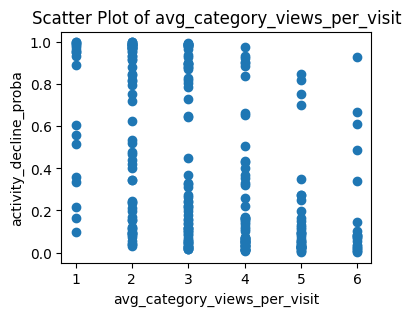

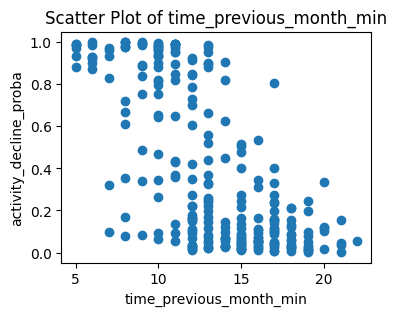

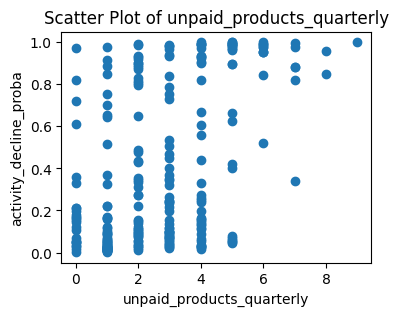

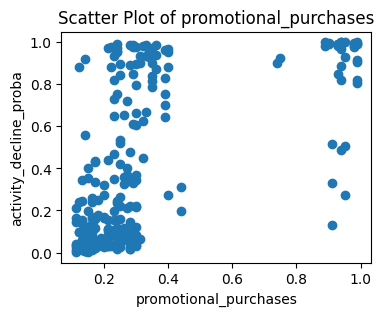

In [115]:
# Анализ на присутствие прямой связи между признаками и вероятностью снижения активности
features = ['pages_per_visit', 
       'avg_category_views_per_visit', 
       'time_previous_month_min', 
       'unpaid_products_quarterly', 
       'promotional_purchases'
       ]

for feature in features:
       plt.figure(figsize=(4, 3))
       plt.scatter(customer_filtered[feature], customer_filtered['activity_decline_proba'])
       plt.title(f'Scatter Plot of {feature}')
       plt.xlabel(feature)
       plt.ylabel('activity_decline_proba')
       plt.show()

Прямой корреляции нет. Проверим по статистическим показателям.

In [116]:
customer_filtered.columns

Index(['id', 'pages_per_visit', 'avg_category_views_per_visit',
       'time_previous_month_min', 'unpaid_products_quarterly',
       'promotional_purchases', 'activity_decline_proba', 'profit'],
      dtype='object')

In [117]:
# Статистические данные по отобранным признакам
customer_filtered[['activity_decline_proba', 'profit']].describe()


,activity_decline_proba,profit
count,260.00,260.00
mean,0.39,3.96
std,0.38,1.05
min,0.00,0.86
25%,0.06,3.22
50%,0.21,4.06
75%,0.83,4.64
max,1.00,6.88


- Средняя вероятности снижения активности относительно - 39%.
- Средняя прибыль 3.96.
- Отберём клиентов, для который вероятность снижения высокая (>= 83%), а прибыль по ним ожидается выше средней (>=3.96)

In [118]:
# Фильтр по высокой вероятности снижения активности и высокой прибыли
_f = customer_filtered['activity_decline_proba'] > 0.8
_f2 = customer_filtered['profit'] >= 3.96
low_activity = customer_filtered[_f & _f2].sort_values(by='activity_decline_proba', ascending=False)

In [119]:
low_activity.head()

,id,pages_per_visit,avg_category_views_per_visit,time_previous_month_min,unpaid_products_quarterly,promotional_purchases,activity_decline_proba,profit
2,215701,2,2,9,5,0.95,1.00,5.05
69,215668,2,2,6,9,0.94,1.00,4.49
14,215418,3,2,8,6,0.94,1.00,4.98
187,215604,4,1,8,5,0.99,1.00,4.86
153,215670,2,3,9,7,0.98,0.99,4.27


In [120]:
# Статистика по пользователям с низкой активностью
low_activity.describe()

,id,pages_per_visit,avg_category_views_per_visit,time_previous_month_min,unpaid_products_quarterly,promotional_purchases,activity_decline_proba,profit
count,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00
mean,"215,601.91",4.04,2.59,9.41,4.30,0.56,0.93,4.77
std,255.74,1.74,1.00,2.73,2.18,0.33,0.06,0.61
min,"215,349.00",1.00,1.00,5.00,0.00,0.12,0.80,3.98
25%,"215,448.00",3.00,2.00,8.00,2.00,0.29,0.89,4.29
50%,"215,564.00",4.00,3.00,10.00,5.00,0.39,0.94,4.73
75%,"215,669.50",5.00,3.00,11.00,6.00,0.94,0.98,5.01
max,"216,636.00",8.00,5.00,17.00,9.00,0.99,1.00,6.88


In [121]:
# Фильтр по пользователям с высокой прибылью, но для которых модель не предсказала высокую вероятность снижения активности
_f3 = customer_filtered['activity_decline_proba'] < 0.39
previous_activity = customer_filtered[_f2 & _f3].sort_values(by='activity_decline_proba', ascending=False)


In [122]:
# Статистика
previous_activity.describe()

,id,pages_per_visit,avg_category_views_per_visit,time_previous_month_min,unpaid_products_quarterly,promotional_purchases,activity_decline_proba,profit
count,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00
mean,"216,152.98",9.82,3.83,14.94,2.09,0.21,0.12,4.70
std,275.96,3.52,1.29,2.98,1.45,0.11,0.10,0.61
min,"215,355.00",4.00,1.00,7.00,0.00,0.11,0.00,3.96
25%,"215,950.25",7.00,3.00,13.00,1.00,0.14,0.04,4.25
50%,"216,190.00",10.00,4.00,15.00,2.00,0.20,0.08,4.49
75%,"216,374.00",12.00,5.00,17.00,3.00,0.26,0.16,5.12
max,"216,641.00",20.00,6.00,21.00,5.00,0.91,0.37,6.59


In [123]:
# Соберём средние показатели по низкой и прежней активности в один датасет
previous_activity_mean = previous_activity[['pages_per_visit', 'avg_category_views_per_visit',
       'time_previous_month_min', 'unpaid_products_quarterly',
       'promotional_purchases']].mean()

In [124]:
previous_activity_mean = pd.DataFrame(previous_activity_mean).reset_index(names='feature')
previous_activity_mean = previous_activity_mean.rename(columns={0: 'previous_activity_mean'})
previous_activity_mean

,feature,previous_activity_mean
0,pages_per_visit,9.82
1,avg_category_views_per_visit,3.83
2,time_previous_month_min,14.94
3,unpaid_products_quarterly,2.09
4,promotional_purchases,0.21


In [125]:
low_activity_mean = low_activity[['pages_per_visit', 'avg_category_views_per_visit',
       'time_previous_month_min', 'unpaid_products_quarterly',
       'promotional_purchases']].mean()

In [126]:
low_activity_mean = pd.DataFrame(low_activity_mean).reset_index(names='feature')
low_activity_mean = low_activity_mean.rename(columns={0: 'low_activity_mean'})
low_activity_mean


,feature,low_activity_mean
0,pages_per_visit,4.04
1,avg_category_views_per_visit,2.59
2,time_previous_month_min,9.41
3,unpaid_products_quarterly,4.30
4,promotional_purchases,0.56


In [127]:
# Итоговый датасет с разницами в метриках
total = low_activity_mean.merge(previous_activity_mean, on='feature')
total

,feature,low_activity_mean,previous_activity_mean
0,pages_per_visit,4.04,9.82
1,avg_category_views_per_visit,2.59,3.83
2,time_previous_month_min,9.41,14.94
3,unpaid_products_quarterly,4.30,2.09
4,promotional_purchases,0.56,0.21


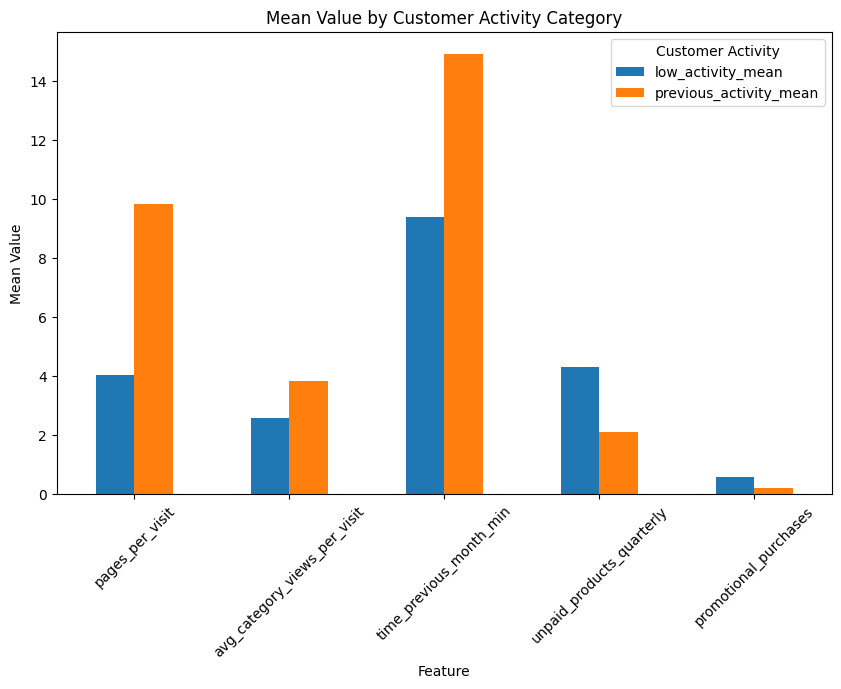

In [128]:
# Визуализация
total.plot(kind='bar', x='feature', figsize=(10, 6))
plt.title('Mean Value by Customer Activity Category')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(title='Customer Activity')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

- Если сравнить средние показатели для покупателей, у которых активность на прежнем уровне, то видно, что активные пользователи в среднем смотрят 10 страниц и 4 категории за посещение, потратили 15 минут на сайте, и при этом у них больше неоплаченных продуктов в корзине и больше покупок по акции.

- Вероятно, стоит увеличивать время Клиентов на сайте магазина. Предлагая в рекомендациях товары, акции, которые будут переводить пользователя на другие страницы, а также напоминать о неоплаченных заказах.
- Также, вероятно, стоит провести опрос, чтобы уточнить, не изменилось ли отношение пользователей к UI/UX веб-интерфейса. Возможно, это сказывается на времени, которое они готовы потратить на сайте магазина.

## 8. Общий вывод



1. В рамках вышеприведённого исследования рассмотрены данные, представленные Заказчиком, описывающие поведение пользователей на сайте, а также информация по прибыли по каждому покупателю.
2. Осуществлена предобработка данных (устранены ошибки, удалены аномалии) и исследовательский анализ данных.
3. Методом GridSearch отобрана лучшая модель для предсказания вероятности снижения покупательской активности.
4. По данным, предсказанным моделью, выделены 5 ключевых метрик, влияющих на покупательскую активность.
5. Определён самый весомый признак - число страниц за визит, из чего была выделена категория пользователей и проанализировано их поведение на сайте.
6. На основании результатов п.5 был сделан вывод, что при снижении покупательской активности стоит уделить внимание повышению времени UX и времени пребывания пользователей на сайте.